<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 1
<br>
<b>Deadline:</b> May 20, 2020 (Wednesday) 23:00
</div>


# Exercise 10.2. Conditional generation with PixelCNN

The goal of this exercise is to do conditional generation with the PixelCNN model.
The basic idea of the conditioning is described in Section 2.3 of [this paper](https://arxiv.org/pdf/1606.05328.pdf). However, we will use a much simpler model.

In [0]:
skip_training = False  # Set this flag to True before validation and submission

In [0]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [0]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [0]:
# Select the device for training (use GPU if you have one)
device = torch.device('cuda:0')
# device = torch.device('cpu')

In [0]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

# Data

In this exercise, we use standard MNIST data.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


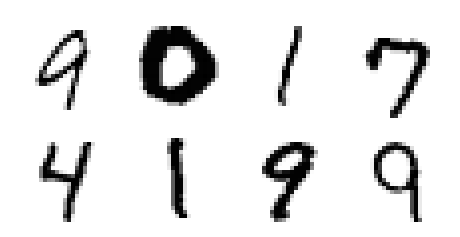

In [8]:
images, labels = iter(trainloader).next()
tools.plot_images(images[:8], ncol=4, cmap=plt.cm.Greys, clim=[0,1])

# Masked convolutional layer

In the cell below, copy the implementation of the `MaskedConv2d` from the PixelCNN notebook.

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, blind_center=False):
        """
        Args:
          in_channels (int): Number of input channels.
          out_channels (int): Number of output channels.
          kernel_size (int): Kernel size similar to nn.Conv2d layer.
          blind_center (bool): If True, the kernel has zero in the center.
        """
        # YOUR CODE HERE
        super().__init__(in_channels, out_channels, kernel_size, bias=False, padding=kernel_size//2)
        
        self.register_buffer('mask', self.weight.data.clone())
        self.mask.fill_(1) # fill mask with ones
        
        # Get number of rows and cols of the mask
        _, _, n_rows, n_cols = self.weight.size()
        
        # Find rows and cols to be "masked"
        i_row = n_rows // 2
        j_col = n_cols // 2
        self.mask[:, :, i_row, (j_col + 1 - blind_center):] = 0
        self.mask[:, :, (i_row + 1):] = 0
        
    def forward(self, x):
        """
        Args:
          x of shape (batch_size, in_channels, height, width): Input images.
        
        Returns:
          y of shape (batch_size, out_channels, height, width): Output images.
        """
        # YOUR CODE HERE
        self.weight.data *= self.mask
        
        return super(MaskedConv2d, self).forward(x)

# Conditional PixelCNN

Conditional PixelCNN models allows to generate images of a desired class. This can be achieved by providing the desired class label to **every layer** of the PixelCNN model. In this notebook, we do it in the following way: the **input of each masked convolutional layer** is:
$$\mathbf{x} + \mathbf{W} \mathbf{h}$$
where
  * $\mathbf{x}$ is the output of the previous layer
  * $\mathbf{h}$ is a 10-dimensional one-hot coded vector of the desired class
  * $\mathbf{W}$ is $c \times 10$ matrix (parameter of a fully-connected layer), where **$c$** is the **number of input channels** in the **masked convolutional layer**.

You need to implement the conditional PixelCNN model in the cell below.

Recommended architecture:
* Use an architecture similar to the PixelCNN architecture in the first notebook.

In [0]:
def MaskConvBlock(n_channels, kernel_size, blind_center=False):
    return nn.Sequential(MaskedConv2d(n_channels, n_channels, kernel_size, blind_center=False),
                         nn.BatchNorm2d(n_channels),
                         nn.ReLU())

In [0]:
class ConditionalPixelCNN(nn.Module):
    def __init__(self, n_channels=64, kernel_size=7):
        """PixelCNN model for conditional generation."""
        # YOUR CODE HERE
        self.n_digits = 10
        super(ConditionalPixelCNN, self).__init__()
        self.MaskConv1 = MaskedConv2d(1, n_channels, kernel_size, blind_center=True)
        self.BatchNorm1 = nn.BatchNorm2d(n_channels)
        
        self.MaskConvBlocks = nn.Sequential(*[MaskConvBlock(n_channels, kernel_size, blind_center=False) for _ in range(7)])
        self.Conv3 = nn.Conv2d(n_channels, 256, kernel_size=1)
        
        self.linear = nn.Linear(self.n_digits, n_channels)

    def forward(self, x, labels):
        """Compute logits of the conditional probabilities p(x_i|x_1, ..., x_{i-1}) of the PixelCNN model.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Tensor of input images.
          labels of shape (batch_size): Long tensor of the desired classes of the generated samples.
        
        Returns:
          logits of shape (batch_size, 256, 28, 28): Tensor of logits of the conditional probabilities
                                                      for each pixel.
        
        NB: Do not use softmax nonlinearity after the last layer.
        """
        # YOUR CODE HERE
        # Transform labels to a one-hot encoded tensor h
        # print("labels.size()", labels.size()) # shape [batch_size]
        h = F.one_hot(labels, num_classes=self.n_digits).float() # shape [batch_size, self.n_digits]
        # print("h.size()", h.size())
        cond = self.linear(h)
        # print("cond.size()", cond.size())

        x = F.relu(self.BatchNorm1(self.MaskConv1(x)))
        # print("x.size()", x.size())
        
        cond = cond.unsqueeze(-1).unsqueeze(-1)
        # print("cond.size()", cond.size())
        input = x + cond
        # x = self.MaskConvBlocks(input)
        # print("len(self.MaskConvBlocks)", len(self.MaskConvBlocks))
        # We need a loop in order to feed both x and the labels for every block
        for i in range(len(self.MaskConvBlocks)):
            x = self.MaskConvBlocks[i](x+cond)
        logits = self.Conv3(x)
        
        return logits

In [12]:
def test_ConditionalPixelCNN_shapes():
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)

    batch_size = 2
    x = torch.ones(batch_size, 1, 28, 28)
    labels = torch.zeros(batch_size, dtype=torch.long)
    # labels = torch.tensor([1, 2, 3], dtype=torch.long)
    y = net(x, labels)
    assert y.shape == torch.Size([batch_size, 256, 28, 28]), f"Bad y.shape: {y.shape}"
    print('Success')

test_ConditionalPixelCNN_shapes()

Success


### Loss function for training conditional PixelCNN

The `loss_fn()` function is identical to the `loss_fn()` from the PixelCNN notebook.

In [0]:
def loss_fn(logits, x):
    """Compute loss of the conditional PixelCNN model. Please see PixelCNN.loss for more details.

    Args:
      logits of shape (batch_size, 256, 28, 28): Logits of the conditional probabilities
                  p(x_i | x_1,...,x_{i-1}) of the 256 intensities of pixel x_i computed using all
                  previous pixel value x_1,...,x_{i-1}.
      x of shape (batch_size, 1, 28, 28): Images used to produce `generated_x`. The values of pixel
                  intensities in x are between 0 and 1.

    Returns:
      loss: Scalar tensor which contains the value of the loss.
    """
    # YOUR CODE HERE
    criterion = nn.CrossEntropyLoss()
    loss = criterion(logits, (x[:,0]*255).long())

    return loss

### Generation procedure

The `generate()` function is *almost* identical to the `generate()` function from the PixelCNN notebook. It additionally receives the labels of the desired classes so that they can be used in the forward computations of the conditional PixelCNN model.

In [0]:
def generate(net, labels, image_size=(28, 28), device='cpu'):
    """Generate samples using a trained conditional PixelCNN model.
    Note: use as device labels.device.

    Args:
      net: Conditional PixelCNN model.
      labels of shape (n_samples): Long tensor of the desired classes of the generated samples.
      image_size: Tuple of image size (height, width).
      device:     Device to use.
    
    Returns:
      samples of shape (n_samples, 1, height, width): Generated samples.
    """
    # YOUR CODE HERE
    n_samples = labels.size()[0]
    height, width = image_size
    net.eval()
    samples = torch.zeros((n_samples, 1, *image_size), device=device) # torch.Size([1, 1, 28, 28])
    # print("samples.size()", samples.size())
    with torch.no_grad():
        for i in range(height):# each row
            for j in range(width): # each col
                out = net(samples, labels)
                probs = F.softmax(out[:, :, i, j], dim=1).data
                pixel_intensity = torch.multinomial(probs, num_samples=1)/255.
                # print("pixel_intensity", pixel_intensity)
                samples[:, :, i, j] = pixel_intensity

    return samples

# Train the model

In [15]:
# Create network
net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
net.to(device)

ConditionalPixelCNN(
  (MaskConv1): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (BatchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (MaskConvBlocks): Sequential(
    (0): Sequential(
      (0): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): MaskedConv2d(64, 64, kernel_

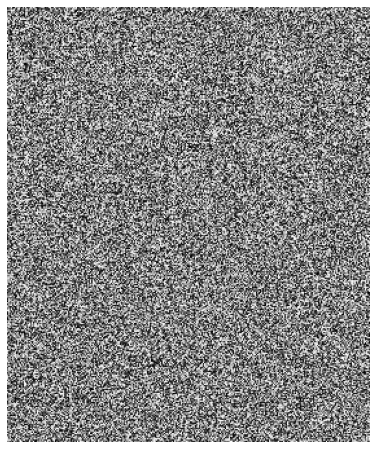

In [22]:
# Plot generated samples for an untrained model
# Note: generation on CPU may take a significant amount of time
if not skip_training:
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 11.

Hints:
- The loss values are similar to the loss values in the PixelCNN notebook.
- Please use this code to plot 120 generated samples after each epoch. This will allow you to track the training progress.
```
# Generate samples
with torch.no_grad():
    net.eval()
    labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
    samples = generate(net, labels, device=device)
    tools.plot_generated_samples(samples, ncol=10)
```
- The generated images should be of great quality but you should definitely recognize the desired classes of the digits.
- **Do not forget to set the model into the training mode by `net.train()` before training.**

Epoch 0
Iteration 500, train_loss=0.8239900469779968
Iteration 1000, train_loss=0.815986692905426
Iteration 1500, train_loss=0.7891721725463867


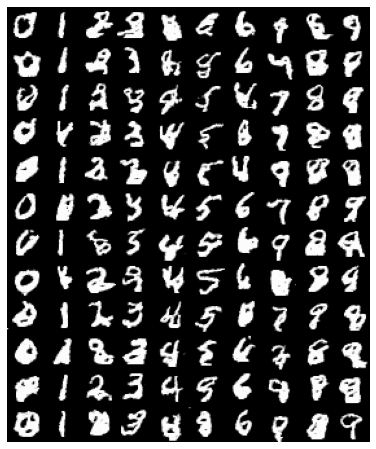

Epoch 1
Iteration 2000, train_loss=0.745281457901001
Iteration 2500, train_loss=0.7421489357948303
Iteration 3000, train_loss=0.7858566641807556
Iteration 3500, train_loss=0.7409148812294006


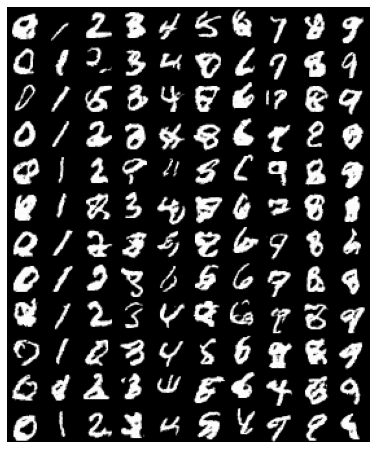

Epoch 2
Iteration 4000, train_loss=0.7917831540107727
Iteration 4500, train_loss=0.6818912029266357
Iteration 5000, train_loss=0.6989780068397522
Iteration 5500, train_loss=0.6489195823669434


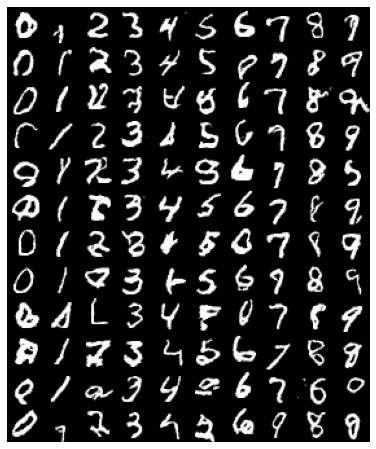

Epoch 3
Iteration 6000, train_loss=0.7670076489448547
Iteration 6500, train_loss=0.7533840537071228
Iteration 7000, train_loss=0.7741326093673706
Iteration 7500, train_loss=0.7017377018928528


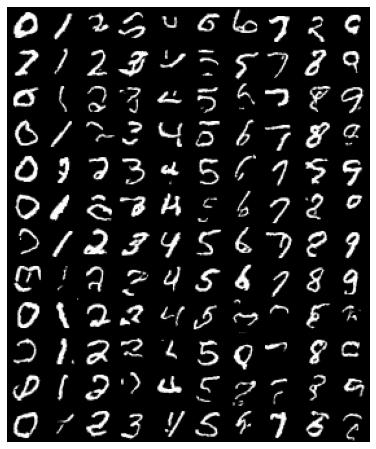

Epoch 4
Iteration 8000, train_loss=0.6923514604568481
Iteration 8500, train_loss=0.68783038854599
Iteration 9000, train_loss=0.7355790138244629


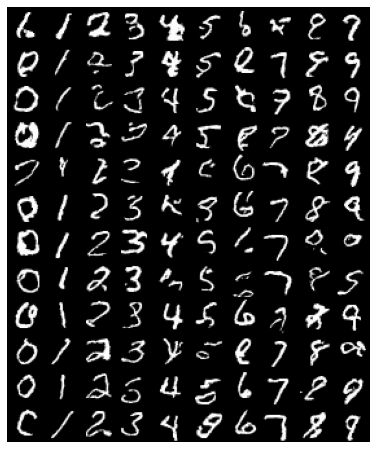

Epoch 5
Iteration 9500, train_loss=0.6870094537734985
Iteration 10000, train_loss=0.6906672716140747
Iteration 10500, train_loss=0.6827290654182434
Iteration 11000, train_loss=0.7108932733535767


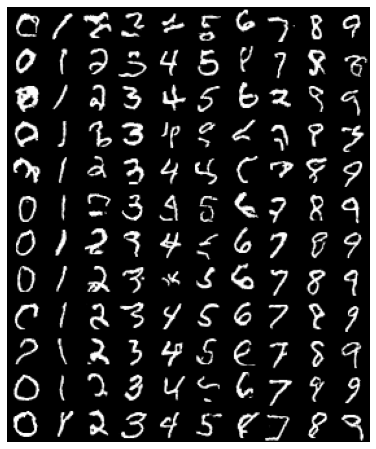

Epoch 6
Iteration 11500, train_loss=0.7251899242401123
Iteration 12000, train_loss=0.6576598286628723
Iteration 12500, train_loss=0.5844692587852478
Iteration 13000, train_loss=0.6356369853019714


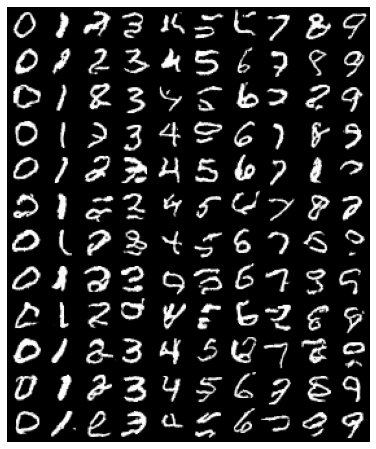

Epoch 7
Iteration 13500, train_loss=0.6905013918876648
Iteration 14000, train_loss=0.7041915059089661
Iteration 14500, train_loss=0.6998065114021301
Iteration 15000, train_loss=0.661730945110321


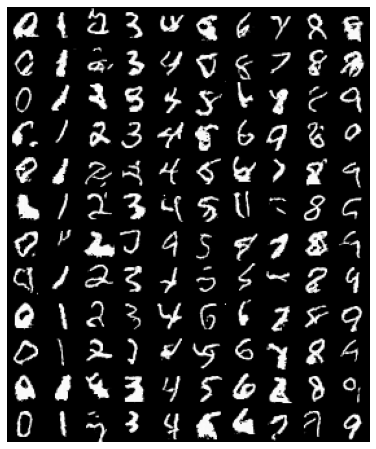

Epoch 8
Iteration 15500, train_loss=0.6803655028343201
Iteration 16000, train_loss=0.7085517644882202
Iteration 16500, train_loss=0.655651867389679


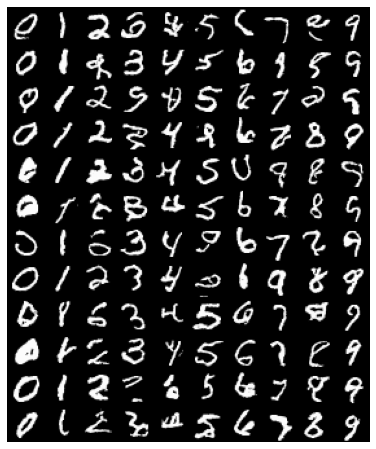

Epoch 9
Iteration 17000, train_loss=0.6132813096046448
Iteration 17500, train_loss=0.6189086437225342
Iteration 18000, train_loss=0.6077668070793152
Iteration 18500, train_loss=0.68378746509552


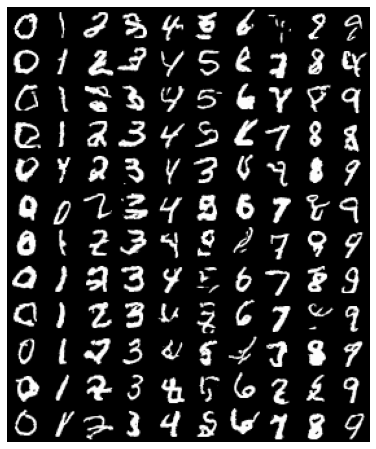

Epoch 10
Iteration 19000, train_loss=0.6295408010482788
Iteration 19500, train_loss=0.6229091286659241
Iteration 20000, train_loss=0.6586390137672424
Iteration 20500, train_loss=0.6092789173126221


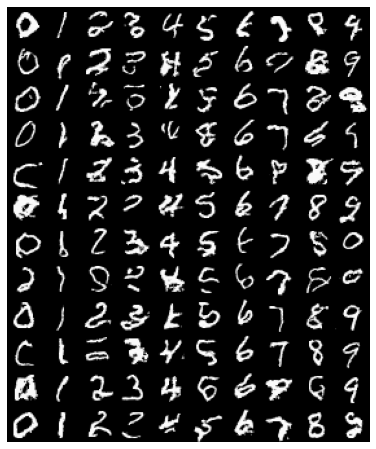

In [24]:
if not skip_training:
    # YOUR CODE HERE
    n_epochs = 11
    iters = 0
    train_loss = []
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    # criterion = nn.CrossEntropyLoss()
    
    for epoch in range(n_epochs):
        print(f"Epoch {epoch}")
        for batch in trainloader:
            net.train()
            optimizer.zero_grad()
            
            images, labels = map(lambda x: x.to(device), batch)
            loss = loss_fn(net(images, labels), images)

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            iters += 1
            if iters % 500 == 0:
                print(f"Iteration {iters}, train_loss={loss.item()}")

        with torch.no_grad():
            net.eval()
            labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
            samples = generate(net, labels, device=device)
            tools.plot_generated_samples(samples, ncol=10)

In [25]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    tools.save_model(net, '10_cond_pixelcnn.pth')
else:
    net = ConditionalPixelCNN(n_channels=64, kernel_size=7)
    tools.load_model(net, '10_cond_pixelcnn.pth', device)

Do you want to save the model (type yes to confirm)? yes
Model saved to 10_cond_pixelcnn.pth.


### Generate samples

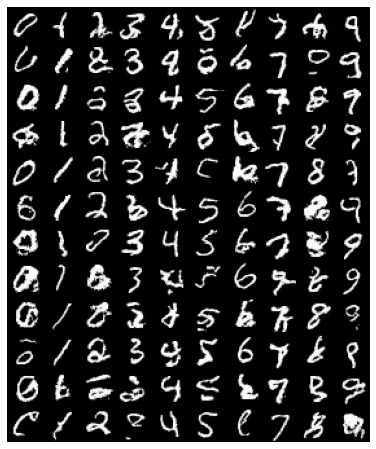

In [26]:
if not skip_training:
    with torch.no_grad():
        net.eval()
        labels = torch.cat([torch.arange(10) for _ in range(12)], dim=0).to(device)
        samples = generate(net, labels, device=device)
        tools.plot_generated_samples(samples, ncol=10)

In [0]:
# This cell tests the training loss of the trained model

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train a conditional PixelCNN model.